In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils  import to_categorical , normalize

from tensorflow.keras.layers  import Flatten , Dense, Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from mtcnn.mtcnn import MTCNN



In [11]:
train = pd.read_csv("data/face/train.csv")
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [12]:
print(f"Total number of rows:{len(train)}")

Total number of rows:15412


In [13]:
options = ["face_with_mask", "face_no_mask"]
train = train[train['classname'].isin(options)].reset_index(drop=True)
train.sort_values(by='name',axis = 0, inplace=True)

In [14]:
train["classname"].unique()

array(['face_no_mask', 'face_with_mask'], dtype=object)

In [15]:
train.head()

,name,x1,x2,y1,y2,classname
4974,1801.jpg,451,186,895,697,face_no_mask
1327,1802.jpg,110,71,273,272,face_with_mask
5524,1803.jpg,126,75,303,333,face_with_mask
2214,1804.jpg,112,113,262,307,face_with_mask
2330,1805.jpg,728,180,853,336,face_with_mask


<BarContainer object of 2 artists>

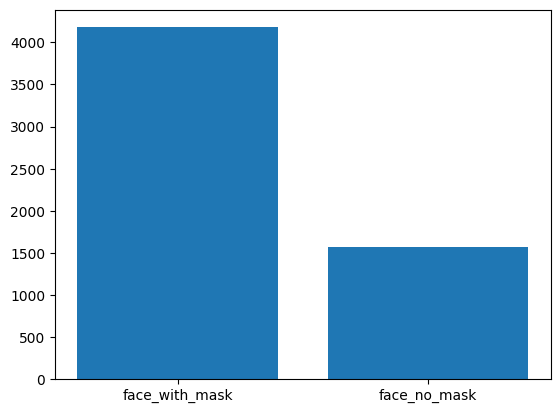

In [16]:
x_value = ["face_with_mask", "face_no_mask"]
y_value = train["classname"].value_counts()
plt.bar(x_value, y_value)

In [17]:
images_file_path = "data/face/Medical mask/Medical mask/Medical mask/images/"

In [18]:
sample_image_name = train.iloc[0]['name']
sample_image_path = images_file_path + sample_image_name

In [19]:
img = plt.imread(sample_image_path)

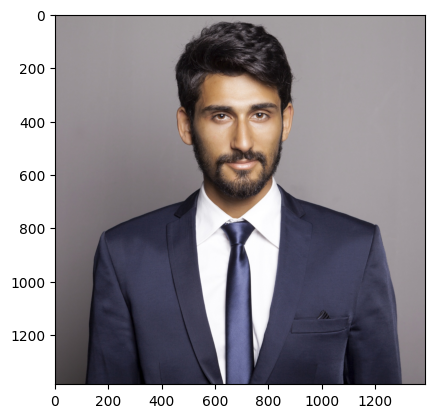

In [20]:
fig,ax = plt.subplots()
ax.imshow(img)

In [21]:
sel_df = train[train['name'] == sample_image_name]
bbox = sel_df[['x1', 'x2', 'y1', 'y2']].values.tolist()

print(bbox)

[[451, 186, 895, 697]]


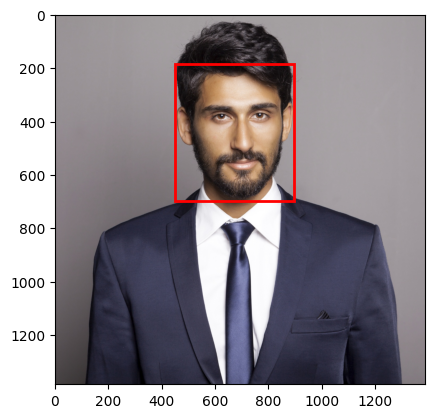

In [22]:
fig, ax = plt.subplots()
ax.imshow(img)

for box in bbox:
    x1, x2, y1, y2 = box
    xy = (x1, x2)
    width = y1 - x1
    height = y2 - x2
    rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)




# **TRAINING DATA PREPARATION**


In [23]:
img_size = 50
data = []
for index , row in train.iterrows():
    name ,x1, x2, y1, y2, classname = row.values
    full_path = images_file_path + name
    img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    crop_img = img_array[x2:y2, x1:y1]
    resized_img = cv2.resize(crop_img, (img_size, img_size))
    data.append([resized_img, classname])

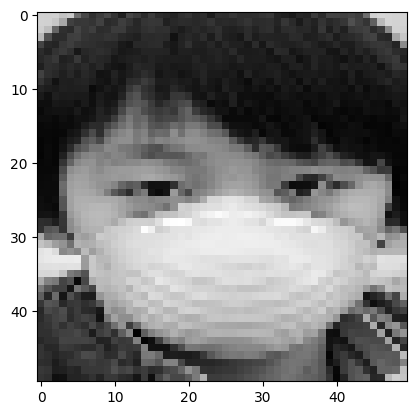

In [24]:
plt.imshow(data[2][0], cmap='gray')

In [25]:
x = []
y = []
for features, labels in data:
    x.append(features)
    y.append(labels) 
x[0].shape

(50, 50)

In [26]:
x= np.array(x).reshape(-1, 50, 50, 1)
x.shape

(5749, 50, 50, 1)

In [27]:
x = normalize(x, axis=1)

In [28]:
print(y[:5])

['face_no_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask', 'face_with_mask']


In [29]:
lbl = LabelEncoder()
y = lbl.fit_transform(y)
print (y[:5])

[0 1 1 1 1]


In [30]:
y = to_categorical(y)

In [31]:
print(y[:5])

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [32]:
input_img_shape = x.shape[1:]
model = Sequential()
model.add(Conv2D(
    filters = 100,
    kernel_size = (3, 3),
    use_bias = True,
    input_shape = input_img_shape,
    activation ='relu',
    strides = 2,
    )
)

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    use_bias = True,
    activation ='relu',
    )
)

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(50, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=1e-3, decay = 1e-6)

model.compile(
    optimizer= opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


C:\Users\goura\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\goura\anaconda3\envs\tfenv\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [33]:
model.fit(x, y,
        epochs=30,
        batch_size=5
        )

Epoch 1/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7235 - loss: 0.5784
Epoch 2/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7419 - loss: 0.4901
Epoch 3/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8052 - loss: 0.4397
Epoch 4/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8288 - loss: 0.3820
Epoch 5/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8373 - loss: 0.3556
Epoch 6/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8545 - loss: 0.3279
Epoch 7/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8700 - loss: 0.2907
Epoch 8/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8841 - loss: 0.2698
Epoch 9/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8958 - loss: 0.2458
Epoch 10/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8997 - loss: 0.2388
Epoch 11/30
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9218 - loss: 0.2000
Epoch 12/30
1150/1150 ━━━━━━━━

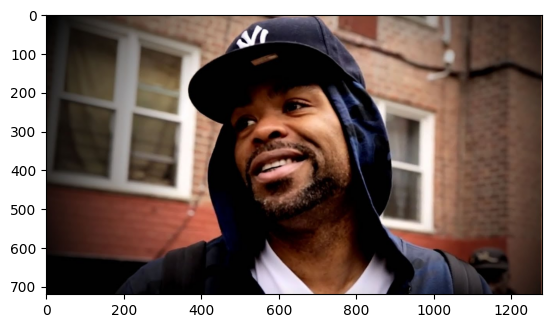

In [34]:
test_image_file_path = "data/face/Medical mask/Medical mask/Medical mask/images/0001.jpg"

img = plt.imread(test_image_file_path)
plt.imshow(img) 

# **MAKE PREDICTIONS ON OUT OF TRAINING SAMPLE IMAGES**

In [35]:
detector = MTCNN()
faces = detector.detect_faces(img)
print(faces)

[{'box': [460, 129, 320, 387], 'confidence': np.float64(0.9908967614173889), 'keypoints': {'nose': [np.int64(556), np.int64(293)], 'mouth_right': [np.int64(675), np.int64(367)], 'right_eye': [np.int64(642), np.int64(232)], 'left_eye': [np.int64(505), np.int64(276)], 'mouth_left': [np.int64(533), np.int64(413)]}}]


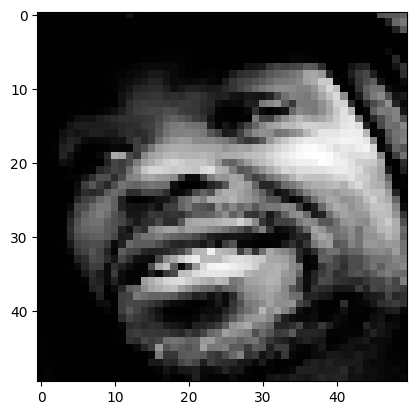

In [36]:
img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)
detector = MTCNN()
faces = detector.detect_faces(img)
x1, x2, width, height = faces[0]['box']
crop_img = img_array[x2: x2+height, x1 : x1+width]
new_img_array = cv2.resize(crop_img, (img_size, img_size))
plt.imshow(new_img_array, cmap='gray')

In [37]:
x= new_img_array.reshape(-1, 50, 50, 1)
x = normalize(x, axis=1)

In [38]:
prediction = model.predict(x)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.0116873  0.98831266]]


In [42]:
np.argmax(prediction)
predicted_class = lbl.inverse_transform([np.argmax(prediction)])
print(predicted_class)

['face_with_mask']


In [43]:
from tensorflow.keras.models import load_model
import joblib  # For saving LabelEncoder

# Save the trained model
model.save("mask_classifier.h5")
print("Model saved as mask_classifier.h5")

# Save the label encoder
joblib.dump(lbl, "label_encoder.pkl")
print("Label encoder saved as label_encoder.pkl")


Model saved as mask_classifier.h5
Label encoder saved as label_encoder.pkl


In [48]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
import joblib

# Load model and label encoder
model = load_model("mask_classifier.h5")
lbl = joblib.load("label_encoder.pkl")

# Initialize webcam and detector
cap = cv2.VideoCapture(0)
detector = MTCNN()
img_size = 50

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector.detect_faces(rgb_frame)

    for face in faces:
        if face['confidence'] < 0.95:
            continue

        x, y, width, height = face['box']
        x, y = max(0, x), max(0, y)
        x2 = min(x + width, gray_frame.shape[1])
        y2 = min(y + height, gray_frame.shape[0])
        face_img = gray_frame[y:y2, x:x2]

        if face_img.size == 0 or face_img.shape[0] < 30 or face_img.shape[1] < 30:
            continue

        resized_face = cv2.resize(face_img, (img_size, img_size))
        normalized_face = resized_face.reshape(-1, img_size, img_size, 1)
        normalized_face = normalize(normalized_face, axis=1)

        prediction = model.predict(normalized_face, verbose=0)
        class_idx = np.argmax(prediction)
        confidence = prediction[0][class_idx]
        label = lbl.inverse_transform([class_idx])[0]

        # Optional: Treat low-confidence predictions as uncertain
        if confidence < 0.80:
            label = "uncertain"

        # Color coding
        if label == "face_with_mask":
            color = (0, 255, 0)
        elif label == "face_no_mask":
            color = (0, 0, 255)
        else:
            color = (0, 255, 255)  # Yellow for uncertain

        # Draw label + box
        cv2.rectangle(frame, (x, y), (x2, y2), color, 2)
        text = f"{label} ({confidence * 100:.1f}%)"
        cv2.putText(frame, text, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Mask Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
